In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string as st
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import punctuation
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import precision_score
from sklearn.model_selection import learning_curve

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# `Importing Raw Data`

In [3]:
train=pd.read_csv('/content/drive/MyDrive/Spam Detection/train.csv')
test=pd.read_csv('/content/drive/MyDrive/Spam Detection/train.csv')

In [4]:
train.head()

,Unnamed: 0,id,Body,Label
0,4006,83044,"Subject: new jcc stuff vince , i ' m gone thr...",0.0
1,6645,36465,Subject: = ? iso - 8859 - 1 ? q ? automaattine...,1.0
2,13662,30041,Subject: we need your help\n dear southtrust c...,1.0
3,7706,72756,bank accountdoctyp html public wnumbercdtd htm...,1.0
4,10855,54804,Subject: dinner speaker - may 23\n vince :\n m...,0.0


In [5]:
train.head()

,Unnamed: 0,id,Body,Label
0,4006,83044,"Subject: new jcc stuff vince , i ' m gone thr...",0.0
1,6645,36465,Subject: = ? iso - 8859 - 1 ? q ? automaattine...,1.0
2,13662,30041,Subject: we need your help\n dear southtrust c...,1.0
3,7706,72756,bank accountdoctyp html public wnumbercdtd htm...,1.0
4,10855,54804,Subject: dinner speaker - may 23\n vince :\n m...,0.0


In [6]:
train.shape

(13153, 4)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13153 entries, 0 to 13152
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  13153 non-null  int64  
 1   id          13153 non-null  int64  
 2   Body        13153 non-null  object 
 3   Label       13153 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 411.2+ KB


### Remove irrelevant columns

In [8]:
train=train.drop(columns=['Unnamed: 0', 'id'])

test_id = test['id']
test=test.drop(columns=['Unnamed: 0', 'id'])

# `Text Processing`

In [9]:
print(train['Body'].loc[0])

Subject: new jcc stuff  vince , i ' m gone through wednesday of next week . i plan to work more on this  over the holiday . contact information is in the . doc  in other news , i didn ' t get the total return swaps finished . i have been  unable to nail down certain details . concepts are quite clear .  - kevin k .


## 1. Removing Punctuations

In [10]:
# Remove all punctuations from the text

def remove_punct(text):
    return ("".join([ch for ch in text if ch not in st.punctuation]))

train["body_text_clean"] = train["Body"].apply(lambda x: remove_punct(x))
test["body_text_clean"] = test["Body"].apply(lambda x: remove_punct(x))
train.head()

,Body,Label,body_text_clean
0,"Subject: new jcc stuff vince , i ' m gone thr...",0.0,Subject new jcc stuff vince i m gone throug...
1,Subject: = ? iso - 8859 - 1 ? q ? automaattine...,1.0,Subject iso 8859 1 q automaattinen pois...
2,Subject: we need your help\n dear southtrust c...,1.0,Subject we need your help\n dear southtrust cu...
3,bank accountdoctyp html public wnumbercdtd htm...,1.0,bank accountdoctyp html public wnumbercdtd htm...
4,Subject: dinner speaker - may 23\n vince :\n m...,0.0,Subject dinner speaker may 23\n vince \n mich...


In [11]:
print(train['body_text_clean'].loc[0])

Subject new jcc stuff  vince  i  m gone through wednesday of next week  i plan to work more on this  over the holiday  contact information is in the  doc  in other news  i didn  t get the total return swaps finished  i have been  unable to nail down certain details  concepts are quite clear    kevin k 


## 2. Tokenization

In [12]:
def tokenize(text):
    text = re.split('\s+' ,text)
    return [x.lower() for x in text]

train["body_text_clean"] = train["body_text_clean"].apply(lambda x: tokenize(x))
test["body_text_clean"] = test["body_text_clean"].apply(lambda x: tokenize(x))
train.head()

,Body,Label,body_text_clean
0,"Subject: new jcc stuff vince , i ' m gone thr...",0.0,"[subject, new, jcc, stuff, vince, i, m, gone, ..."
1,Subject: = ? iso - 8859 - 1 ? q ? automaattine...,1.0,"[subject, iso, 8859, 1, q, automaattinen, pois..."
2,Subject: we need your help\n dear southtrust c...,1.0,"[subject, we, need, your, help, dear, southtru..."
3,bank accountdoctyp html public wnumbercdtd htm...,1.0,"[bank, accountdoctyp, html, public, wnumbercdt..."
4,Subject: dinner speaker - may 23\n vince :\n m...,0.0,"[subject, dinner, speaker, may, 23, vince, mic..."


In [13]:
print(len(train['body_text_clean'].loc[0]))
print(train['body_text_clean'].loc[0])

57
['subject', 'new', 'jcc', 'stuff', 'vince', 'i', 'm', 'gone', 'through', 'wednesday', 'of', 'next', 'week', 'i', 'plan', 'to', 'work', 'more', 'on', 'this', 'over', 'the', 'holiday', 'contact', 'information', 'is', 'in', 'the', 'doc', 'in', 'other', 'news', 'i', 'didn', 't', 'get', 'the', 'total', 'return', 'swaps', 'finished', 'i', 'have', 'been', 'unable', 'to', 'nail', 'down', 'certain', 'details', 'concepts', 'are', 'quite', 'clear', 'kevin', 'k', '']


In [14]:
# Remove tokens of length less than 3

def remove_small_words(text):
    return [x for x in text if len(x) > 3 ]

train["body_text_clean"] = train["body_text_clean"].apply(lambda x: remove_small_words(x))
test["body_text_clean"] = test["body_text_clean"].apply(lambda x: remove_small_words(x))
train.head()

,Body,Label,body_text_clean
0,"Subject: new jcc stuff vince , i ' m gone thr...",0.0,"[subject, stuff, vince, gone, through, wednesd..."
1,Subject: = ? iso - 8859 - 1 ? q ? automaattine...,1.0,"[subject, 8859, automaattinen, poissaolovastau..."
2,Subject: we need your help\n dear southtrust c...,1.0,"[subject, need, your, help, dear, southtrust, ..."
3,bank accountdoctyp html public wnumbercdtd htm...,1.0,"[bank, accountdoctyp, html, public, wnumbercdt..."
4,Subject: dinner speaker - may 23\n vince :\n m...,0.0,"[subject, dinner, speaker, vince, michael, cre..."


In [15]:
print(len(train['body_text_clean'].loc[0]))
print(train['body_text_clean'].loc[0])

34
['subject', 'stuff', 'vince', 'gone', 'through', 'wednesday', 'next', 'week', 'plan', 'work', 'more', 'this', 'over', 'holiday', 'contact', 'information', 'other', 'news', 'didn', 'total', 'return', 'swaps', 'finished', 'have', 'been', 'unable', 'nail', 'down', 'certain', 'details', 'concepts', 'quite', 'clear', 'kevin']


## 3. Removing Stopwords

In [16]:
stopwords = nltk.corpus.stopwords.words("english")

def remove_stopwords(token):
    text = [word for word in token if word not in stopwords]# to remove all stopwords
    return text

train["body_text_clean"] = train["body_text_clean"].apply(lambda x: remove_stopwords(x))
test["body_text_clean"] = test["body_text_clean"].apply(lambda x: remove_stopwords(x))
train.head()

,Body,Label,body_text_clean
0,"Subject: new jcc stuff vince , i ' m gone thr...",0.0,"[subject, stuff, vince, gone, wednesday, next,..."
1,Subject: = ? iso - 8859 - 1 ? q ? automaattine...,1.0,"[subject, 8859, automaattinen, poissaolovastau..."
2,Subject: we need your help\n dear southtrust c...,1.0,"[subject, need, help, dear, southtrust, custom..."
3,bank accountdoctyp html public wnumbercdtd htm...,1.0,"[bank, accountdoctyp, html, public, wnumbercdt..."
4,Subject: dinner speaker - may 23\n vince :\n m...,0.0,"[subject, dinner, speaker, vince, michael, cre..."


In [17]:
print(len(train['body_text_clean'].loc[0]))
print(train['body_text_clean'].loc[0])

25
['subject', 'stuff', 'vince', 'gone', 'wednesday', 'next', 'week', 'plan', 'work', 'holiday', 'contact', 'information', 'news', 'total', 'return', 'swaps', 'finished', 'unable', 'nail', 'certain', 'details', 'concepts', 'quite', 'clear', 'kevin']


## 4. Stemming

Stemming aims to reduce words to their root or base form. It involves removing suffixes or prefixes from words to find a common linguistic root.

For example, "jumping," "jumps," and "jumped" would all be reduced to "jump."

In [18]:
ps = nltk.PorterStemmer()

def stemming(t_text):
    text = [ps.stem(word) for word in t_text]
    return text

train["body_text_clean"] = train["body_text_clean"].apply(lambda x: stemming(x))
test["body_text_clean"] = test["body_text_clean"].apply(lambda x: stemming(x))
train.head()

,Body,Label,body_text_clean
0,"Subject: new jcc stuff vince , i ' m gone thr...",0.0,"[subject, stuff, vinc, gone, wednesday, next, ..."
1,Subject: = ? iso - 8859 - 1 ? q ? automaattine...,1.0,"[subject, 8859, automaattinen, poissaolovastau..."
2,Subject: we need your help\n dear southtrust c...,1.0,"[subject, need, help, dear, southtrust, custom..."
3,bank accountdoctyp html public wnumbercdtd htm...,1.0,"[bank, accountdoctyp, html, public, wnumbercdt..."
4,Subject: dinner speaker - may 23\n vince :\n m...,0.0,"[subject, dinner, speaker, vinc, michael, crew..."


In [19]:
print(len(train['body_text_clean'].loc[0]))
print(train['body_text_clean'].loc[0])

25
['subject', 'stuff', 'vinc', 'gone', 'wednesday', 'next', 'week', 'plan', 'work', 'holiday', 'contact', 'inform', 'news', 'total', 'return', 'swap', 'finish', 'unabl', 'nail', 'certain', 'detail', 'concept', 'quit', 'clear', 'kevin']


## 5. Lemmatization

Lemmatization involves reducing words to their base or dictionary form, known as the "lemma." Unlike stemming, lemmatization takes into account the word's context and grammar, resulting in a more meaningful and accurate transformation.

For example, "running," "ran," and "runs" would all be lemmatized to "run."

In [20]:
# Apply lemmatization on tokens
def lemmatize(text):
    word_net = WordNetLemmatizer()
    return [word_net.lemmatize(word) for word in text]

train["body_text_clean"] = train["body_text_clean"].apply(lambda x: lemmatize(x))
test["body_text_clean"] = test["body_text_clean"].apply(lambda x: lemmatize(x))
train.head()

,Body,Label,body_text_clean
0,"Subject: new jcc stuff vince , i ' m gone thr...",0.0,"[subject, stuff, vinc, gone, wednesday, next, ..."
1,Subject: = ? iso - 8859 - 1 ? q ? automaattine...,1.0,"[subject, 8859, automaattinen, poissaolovastau..."
2,Subject: we need your help\n dear southtrust c...,1.0,"[subject, need, help, dear, southtrust, custom..."
3,bank accountdoctyp html public wnumbercdtd htm...,1.0,"[bank, accountdoctyp, html, public, wnumbercdt..."
4,Subject: dinner speaker - may 23\n vince :\n m...,0.0,"[subject, dinner, speaker, vinc, michael, crew..."


In [21]:
print(len(train['body_text_clean'].loc[0]))
print(train['body_text_clean'].loc[0])

25
['subject', 'stuff', 'vinc', 'gone', 'wednesday', 'next', 'week', 'plan', 'work', 'holiday', 'contact', 'inform', 'news', 'total', 'return', 'swap', 'finish', 'unabl', 'nail', 'certain', 'detail', 'concept', 'quit', 'clear', 'kevin']


## Return Sentences

In [22]:
# Create sentences to get clean text as input for vectors

def return_sentences(tokens):
    return " ".join([word for word in tokens])

train["body_text_clean"] = train["body_text_clean"].apply(lambda x: return_sentences(x))
test["body_text_clean"] = test["body_text_clean"].apply(lambda x: return_sentences(x))
train.head()

,Body,Label,body_text_clean
0,"Subject: new jcc stuff vince , i ' m gone thr...",0.0,subject stuff vinc gone wednesday next week pl...
1,Subject: = ? iso - 8859 - 1 ? q ? automaattine...,1.0,subject 8859 automaattinen poissaolovastau spa...
2,Subject: we need your help\n dear southtrust c...,1.0,subject need help dear southtrust custom fraud...
3,bank accountdoctyp html public wnumbercdtd htm...,1.0,bank accountdoctyp html public wnumbercdtd htm...
4,Subject: dinner speaker - may 23\n vince :\n m...,0.0,subject dinner speaker vinc michael crew would...


In [23]:
#Total length removal (Train Set)
print("Train Set:")
print("Original Length:",train.Body.str.len().sum())
print("Cleaned Length:",train.body_text_clean.str.len().sum())
print("Total Words Removed:",(train.Body.str.len().sum()) - (train.body_text_clean.str.len().sum()))
print()

#Total length removal (Test Set)
print("Test Set:")
print("Original Length:",test.Body.str.len().sum())
print("Cleaned Length:",test.body_text_clean.str.len().sum())
print("Total Words Removed:",(test.Body.str.len().sum()) - (test.body_text_clean.str.len().sum()))

Train Set:
Original Length: 19225069
Cleaned Length: 11041714
Total Words Removed: 8183355

Test Set:
Original Length: 19225069
Cleaned Length: 11041714
Total Words Removed: 8183355


In [24]:
train

,Body,Label,body_text_clean
0,"Subject: new jcc stuff vince , i ' m gone thr...",0.0,subject stuff vinc gone wednesday next week pl...
1,Subject: = ? iso - 8859 - 1 ? q ? automaattine...,1.0,subject 8859 automaattinen poissaolovastau spa...
2,Subject: we need your help\n dear southtrust c...,1.0,subject need help dear southtrust custom fraud...
3,bank accountdoctyp html public wnumbercdtd htm...,1.0,bank accountdoctyp html public wnumbercdtd htm...
4,Subject: dinner speaker - may 23\n vince :\n m...,0.0,subject dinner speaker vinc michael crew would...
...,...,...,...
13148,Subject: re : test dear vince : the email add...,0.0,subject test dear vinc email address candic cg...
13149,"Subject: all graphics software available , che...",1.0,subject graphic softwar avail cheap version go...
13150,Subject: introduction of the european gas advi...,0.0,subject introduct european advisori servic eur...
13151,"Subject: credit business plan hi jeff , my r...",0.0,subject credit busi plan jeff research colleag...


# `Save processed data`

In [25]:
# train.to_csv('processed_train_data.csv')
# test.to_csv('processed_test_data.csv')

In [26]:
# train=pd.read_csv('processed_train_data.csv')
# test=pd.read_csv('processed_test_data.csv')

In [27]:
# train

# `EDA`

Text(0.5, 1.0, 'Number of Spam and Ham')

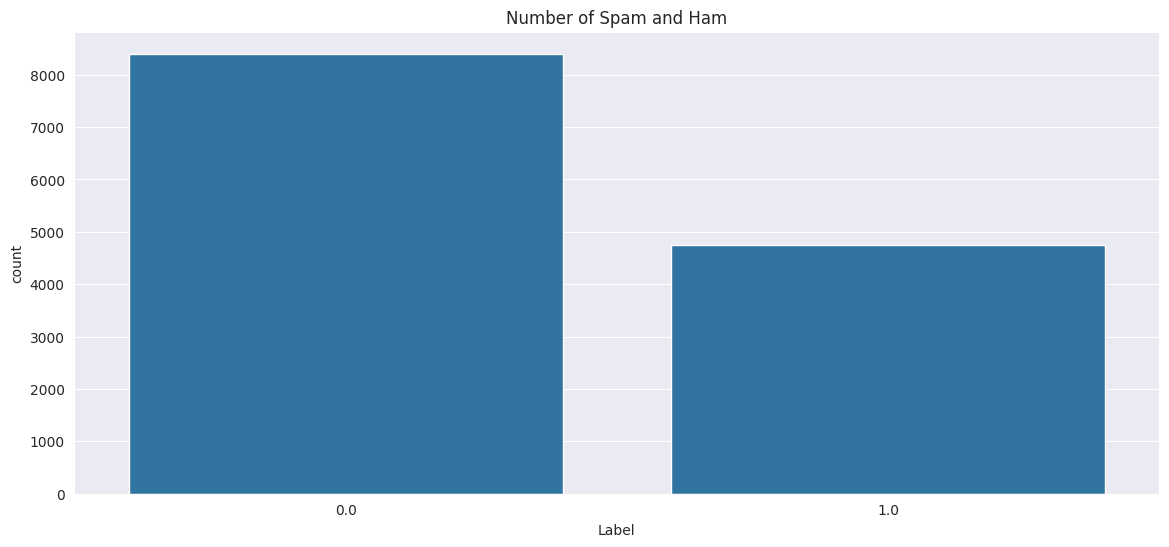

In [28]:
# plot for count of spam and ham in data
plt.figure(figsize=(14,6))
sns.set_style('darkgrid')
sns.countplot(x='Label',data=train)
plt.title('Number of Spam and Ham')

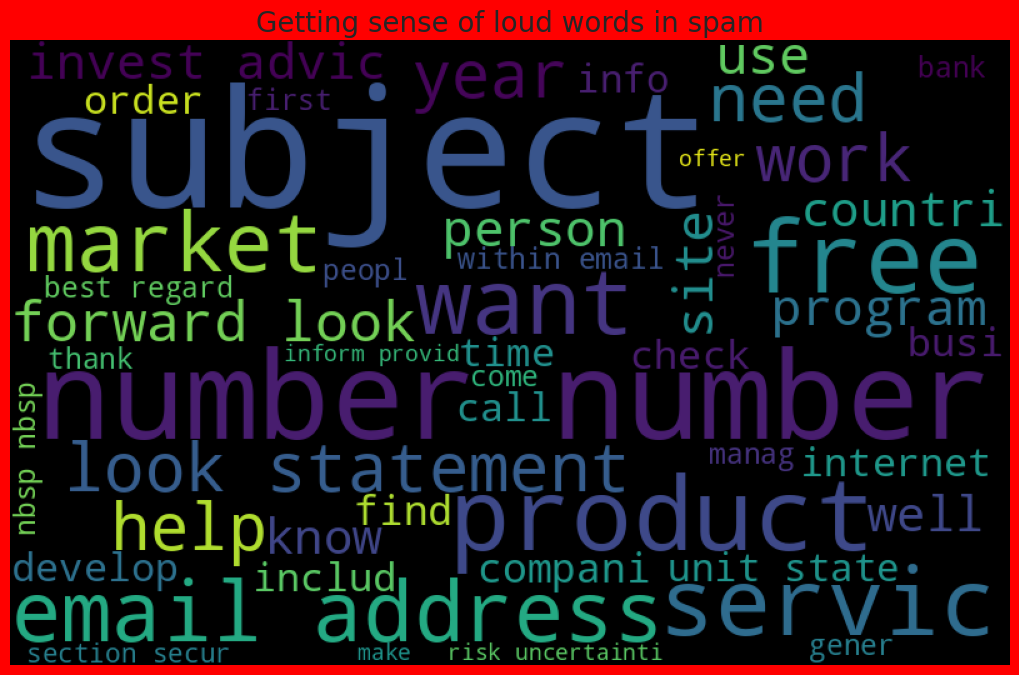

In [29]:
#Getting sense of loud words in spam

spams = train['body_text_clean'][train['Label']==1]
spam_cloud = WordCloud(width=800,height=500,background_color='black',max_words=50).generate(' '.join(spams))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.title("Getting sense of loud words in spam",fontsize=20);
plt.axis('off')
plt.tight_layout(pad=0)
# plt.savefig("spam.png")
plt.show()

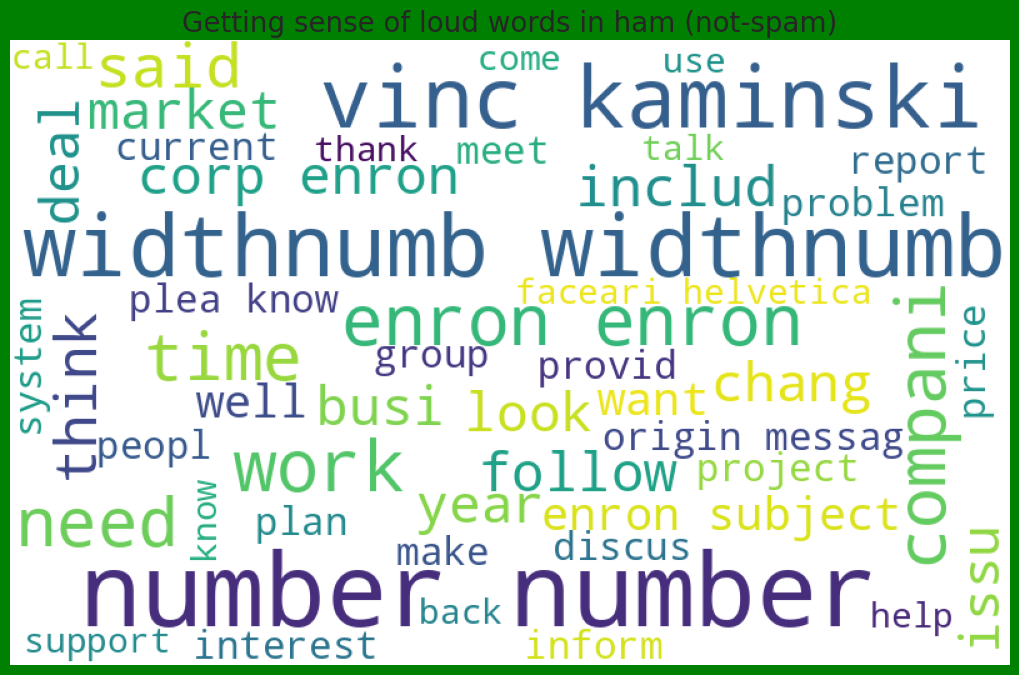

In [30]:
#Getting sense of loud words in not-spam

not_spams = train['body_text_clean'][train['Label']==0]
spam_cloud = WordCloud(width=800,height=500,background_color='white',max_words=50).generate(' '.join(not_spams))

plt.figure(figsize=(10,8),facecolor='g')
plt.imshow(spam_cloud)
plt.title("Getting sense of loud words in ham (not-spam)",fontsize=20);

plt.axis('off')
plt.tight_layout(pad=0)
# plt.savefig("ham.png")
plt.show()

# `Feature Extraction & Clustring`


## Tf-idf Vectorizer with MiniBatch K-means

In [31]:
############################################## MiniBatch K-means <=> Tf-idf ####################################################

## Part 1: Fitting the MiniBatchKMeans Model using Tf-idf Vectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=9, smooth_idf=True, sublinear_tf=True, norm='l2')

n_clusters = 2
kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=15)

pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('kmeans', kmeans)
])

pipeline.fit(train['body_text_clean'])
train_cluster_labels_tfidf_MiniBatchKMeans = pipeline.predict(train['body_text_clean'])

train_precision = precision_score(train['Label'], train_cluster_labels_tfidf_MiniBatchKMeans)
print("Train Precision Score:", train_precision)

Train Precision Score: 0.6060373497058071


In [32]:
## Part 2: Predicting Cluster Labels for Test Data

test_cluster_labels_tfidf_MiniBatchKMeans = pipeline.predict(test['body_text_clean'])
print("Test Cluster Labels:", test_cluster_labels_tfidf_MiniBatchKMeans)

Test Cluster Labels: [0 1 1 ... 0 0 0]


In [34]:
## Part 3: Saving Predictions to CSV

submission = pd.DataFrame({'id': test_id, 'Label': test_cluster_labels_tfidf_MiniBatchKMeans})
submission.to_csv('test_tfidf_MiniBatchKMeans.csv', index=False)

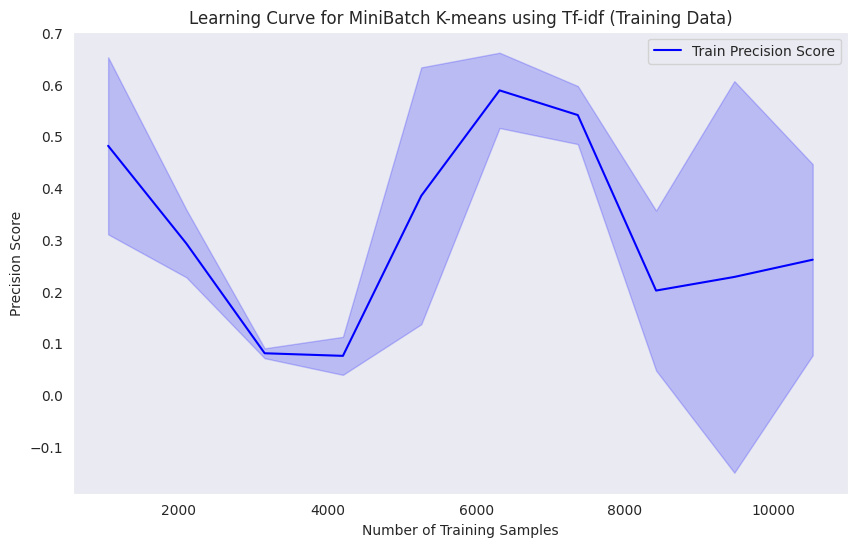

In [35]:
# Create a learning curve plot for MiniBatch K-means using Tf-idf
train_sizes, train_scores, _ = learning_curve(
    estimator=pipeline,
    X=train['body_text_clean'],
    y=train['Label'],
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='precision',
    random_state=9
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Train Precision Score', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.xlabel("Number of Training Samples")
plt.ylabel("Precision Score")
plt.title("Learning Curve for MiniBatch K-means using Tf-idf (Training Data)")
plt.legend(loc="best")
plt.grid()
# plt.savefig('mm.jpg')
plt.show()

## Bag of Words with MiniBatch K-means

In [36]:
############################################## MiniBatch K-means <=> Bag of Words ##############################################

## Part 1: Fitting the MiniBatchKMeans Model using Bag of Words Vectorizer

bow_vectorizer = CountVectorizer(max_df=0.8, min_df=5)

n_clusters = 2
kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=6)


pipeline = Pipeline([
    ('bow', bow_vectorizer),
    ('kmeans', kmeans)
])

pipeline.fit(train['body_text_clean'])
train_cluster_labels_bow_MiniBatchKMeans = pipeline.predict(train['body_text_clean'])

train_precision = precision_score(train['Label'], train_cluster_labels_bow_MiniBatchKMeans)
print("Train Precision Score:", train_precision)

Train Precision Score: 0.36443148688046645


In [37]:
## Part 2: Predicting Cluster Labels for Test Data

test_cluster_labels_bow_MiniBatchKMeans = pipeline.predict(test['body_text_clean'])
print("Test Cluster Labels:", test_cluster_labels_bow_MiniBatchKMeans)

Test Cluster Labels: [1 1 1 ... 1 1 1]


In [39]:
## Part 3: Saving Predictions to CSV

submission_2 = pd.DataFrame({'id': test_id, 'Label': test_cluster_labels_bow_MiniBatchKMeans})
submission_2.to_csv('test_bow_MiniBatchKMeans.csv', index=False)